<a href="https://colab.research.google.com/github/n1la9jan/AnimalPrediction/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [11]:
import torch
from torch import nn
from torch.optim import adam
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pandas as pd
import os

# Setting to Cuda

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device = {device}")

Device = cuda


# Loading image to Dataframe

In [13]:
image_path = []
labels = []
for i in os.listdir("/content/drive/MyDrive/Colab Notebooks/Cat and Dog prediction /afhq"):
  for label in os.listdir(f"/content/drive/MyDrive/Colab Notebooks/Cat and Dog prediction /afhq/{i}"):
    for img in os.listdir(f"/content/drive/MyDrive/Colab Notebooks/Cat and Dog prediction /afhq/{i}/{label}"):
      image_path.append(f"/content/drive/MyDrive/Colab Notebooks/Cat and Dog prediction /afhq/{i}/{label}/{img}")
      labels.append(label)

df = pd.DataFrame(zip(image_path, labels), columns=["image_path", "labels"])
df.head()

,image_path,labels
0,/content/drive/MyDrive/Colab Notebooks/Cat and...,wild
1,/content/drive/MyDrive/Colab Notebooks/Cat and...,wild
2,/content/drive/MyDrive/Colab Notebooks/Cat and...,wild
3,/content/drive/MyDrive/Colab Notebooks/Cat and...,wild
4,/content/drive/MyDrive/Colab Notebooks/Cat and...,wild


# Data Split

In [14]:
train = df.sample(frac = 0.7)
test = df.drop(train.index)
val = test.sample(frac = 0.5)
test = test.drop(val.index)

#show shapes
print(f"Train data {train.shape}\nVal Data = {val.shape}\nTest Data = {test.shape}")


Train data (11307, 2)
Val Data = (2423, 2)
Test Data = (2423, 2)


# Preprocessing

In [15]:
#convert the label in integer
label_encoder = LabelEncoder()
label_encoder.fit(df['labels'])

#transform all the images in an universal size
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float),
])

# Custom Dataset Class & Object

In [16]:
class CustomImageDataset(Dataset):
  def __init__(self, df, transform = None):
    self.df = df
    self.transform = transform
    self.labels = torch.tensor(label_encoder.transform(df['labels'])).to(device)

  def __len__(self):
    return self.df.shape[0]

  def __getitem__(self, index):
    image_path = self.df.iloc[index, 0]
    #assigned labels column as label
    label = self.labels[index]
    image = Image.open(image_path).convert('RGB')

    if self.transform:
      image = self.transform(image).to(device)

      return image, label

In [17]:
train_dataset = CustomImageDataset(df=train, transform=transform)
val_dataset = CustomImageDataset(df=val, transform=transform)
test_dataset = CustomImageDataset(df=test, transform=transform)

In [18]:
#visualisation of the output
train_dataset.__getitem__(2)
label_encoder.inverse_transform([2])

array(['wild'], dtype=object)

# Visualise the images

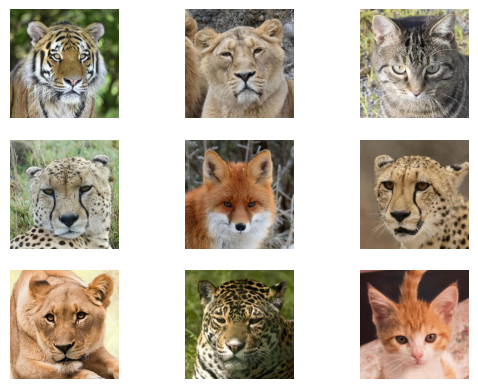

In [19]:
n_rows = 3
n_cols = 3
f, axarr = plt.subplots(n_rows, n_cols)
for row in range(n_rows):
  for col in range(n_cols):
    image = Image.open(df.sample(n=1)["image_path"].iloc[0]).convert("RGB")
    axarr[row, col].imshow(image)
    axarr[row, col].axis("off")

plt.show()

# HyperParameters

In [20]:
LR = 1e-4
BATCH_SIZE = 16
EPOCHS = 10
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size= BATCH_SIZE, shuffle = True)

# Model Building

In [32]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding = 1)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding = 1)
    self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding = 1)

    self.pooling = nn.MaxPool2d(2,2)
    self.relu = nn.ReLU()
    self.flatten = nn.Flatten()
    self.linear = nn.Linear((128*16*16), 128)
    self.output = nn.Linear(128, len(df['labels'].unique()))

  def forward(self, x):
    x = self.conv1(x)
    x = self.pooling(x)
    x = self.relu(x)

    x = self.conv2(x)
    x = self.pooling(x)
    x = self.relu(x)

    x = self.conv3(x)
    x = self.pooling(x)
    x = self.relu(x)

    x = self.flatten(x)
    x = self.linear(x)
    x = self.output(x)

    return x

In [34]:
model = Net().to(device)

In [35]:
from torchsummary import summary
summary(model, input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
         MaxPool2d-2           [-1, 32, 64, 64]               0
              ReLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          18,496
         MaxPool2d-5           [-1, 64, 32, 32]               0
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 128, 32, 32]          73,856
         MaxPool2d-8          [-1, 128, 16, 16]               0
              ReLU-9          [-1, 128, 16, 16]               0
          Flatten-10                [-1, 32768]               0
           Linear-11                  [-1, 128]       4,194,432
           Linear-12                    [-1, 3]             387
Total params: 4,288,067
Trainable params: 4,288,067
Non-trainable params: 0
---------------------------